In [6]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import os
import pandas as pd
from chefboost import Chefboost as chef

In [7]:
from utils import *

In [8]:
current_dir = os.getcwd()
folder = '/data/results_international/'
result_file = '/adj_final_results.csv'
rubicology_file = 'all_games_RWC2023_fixed.csv'
split_df = current_dir+folder+'split_df_teams.csv'

In [9]:
data = load_data(split_df, value='normal',draw=True)
#take half victories and half loss
#data = data.iloc[::2, :].reset_index(drop=True)
data['Outcome'] = load_data(split_df, value='diff',draw=True)['Outcome']
mean_scrum = data['% Scrums Successful'].mean()
data['% Scrums Successful'] = data['% Scrums Successful'].fillna(mean_scrum)
print(data.shape)
data = data.dropna()

error
(96, 38)


In [10]:
variables_to_remove = ['Game ID', 'Date', 'Team', 'Score','Tries', 'Conversions','Goal Kicks Successful', 'Goal Kicks Attempted']

In [11]:
X =data.drop(columns=variables_to_remove)
#X['Outcome'] = X['Outcome'].apply(lambda x : 'Win' if x==1 else 'Loss')
#X['Outcome'].rename('Decision', inplace=True)
y=data['Outcome']
X.drop(columns='Outcome', inplace=True)
features = X.columns
mean_scrum = X['% Scrums Successful'].mean()
X = X.fillna(mean_scrum)
col = list(X.columns)

In [19]:
# Number of trees in random forest
criterion = ['gini','entropy']
# Number of features to consider at every split
max_features = [None,'log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [3,4,5]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree

random_grid = {'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [21]:
rf = DecisionTreeClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 4, verbose=2, n_jobs = -1, return_train_score=True)
# Fit the random search model
rf_random.fit(X, y)

Fitting 4 folds for each of 162 candidates, totalling 648 fits
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, verbose=2)

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10}


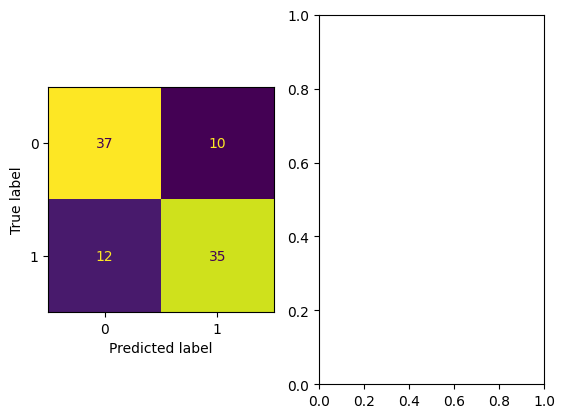

In [22]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

best_random = rf_random.best_estimator_
pred =   best_random .predict(X)
fig, ax = plt.subplots(1, 2)
cm = sklearn.metrics.confusion_matrix(y, pred)
displ = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
displ.plot(ax=ax[0], colorbar=False)
print(rf_random.best_params_)

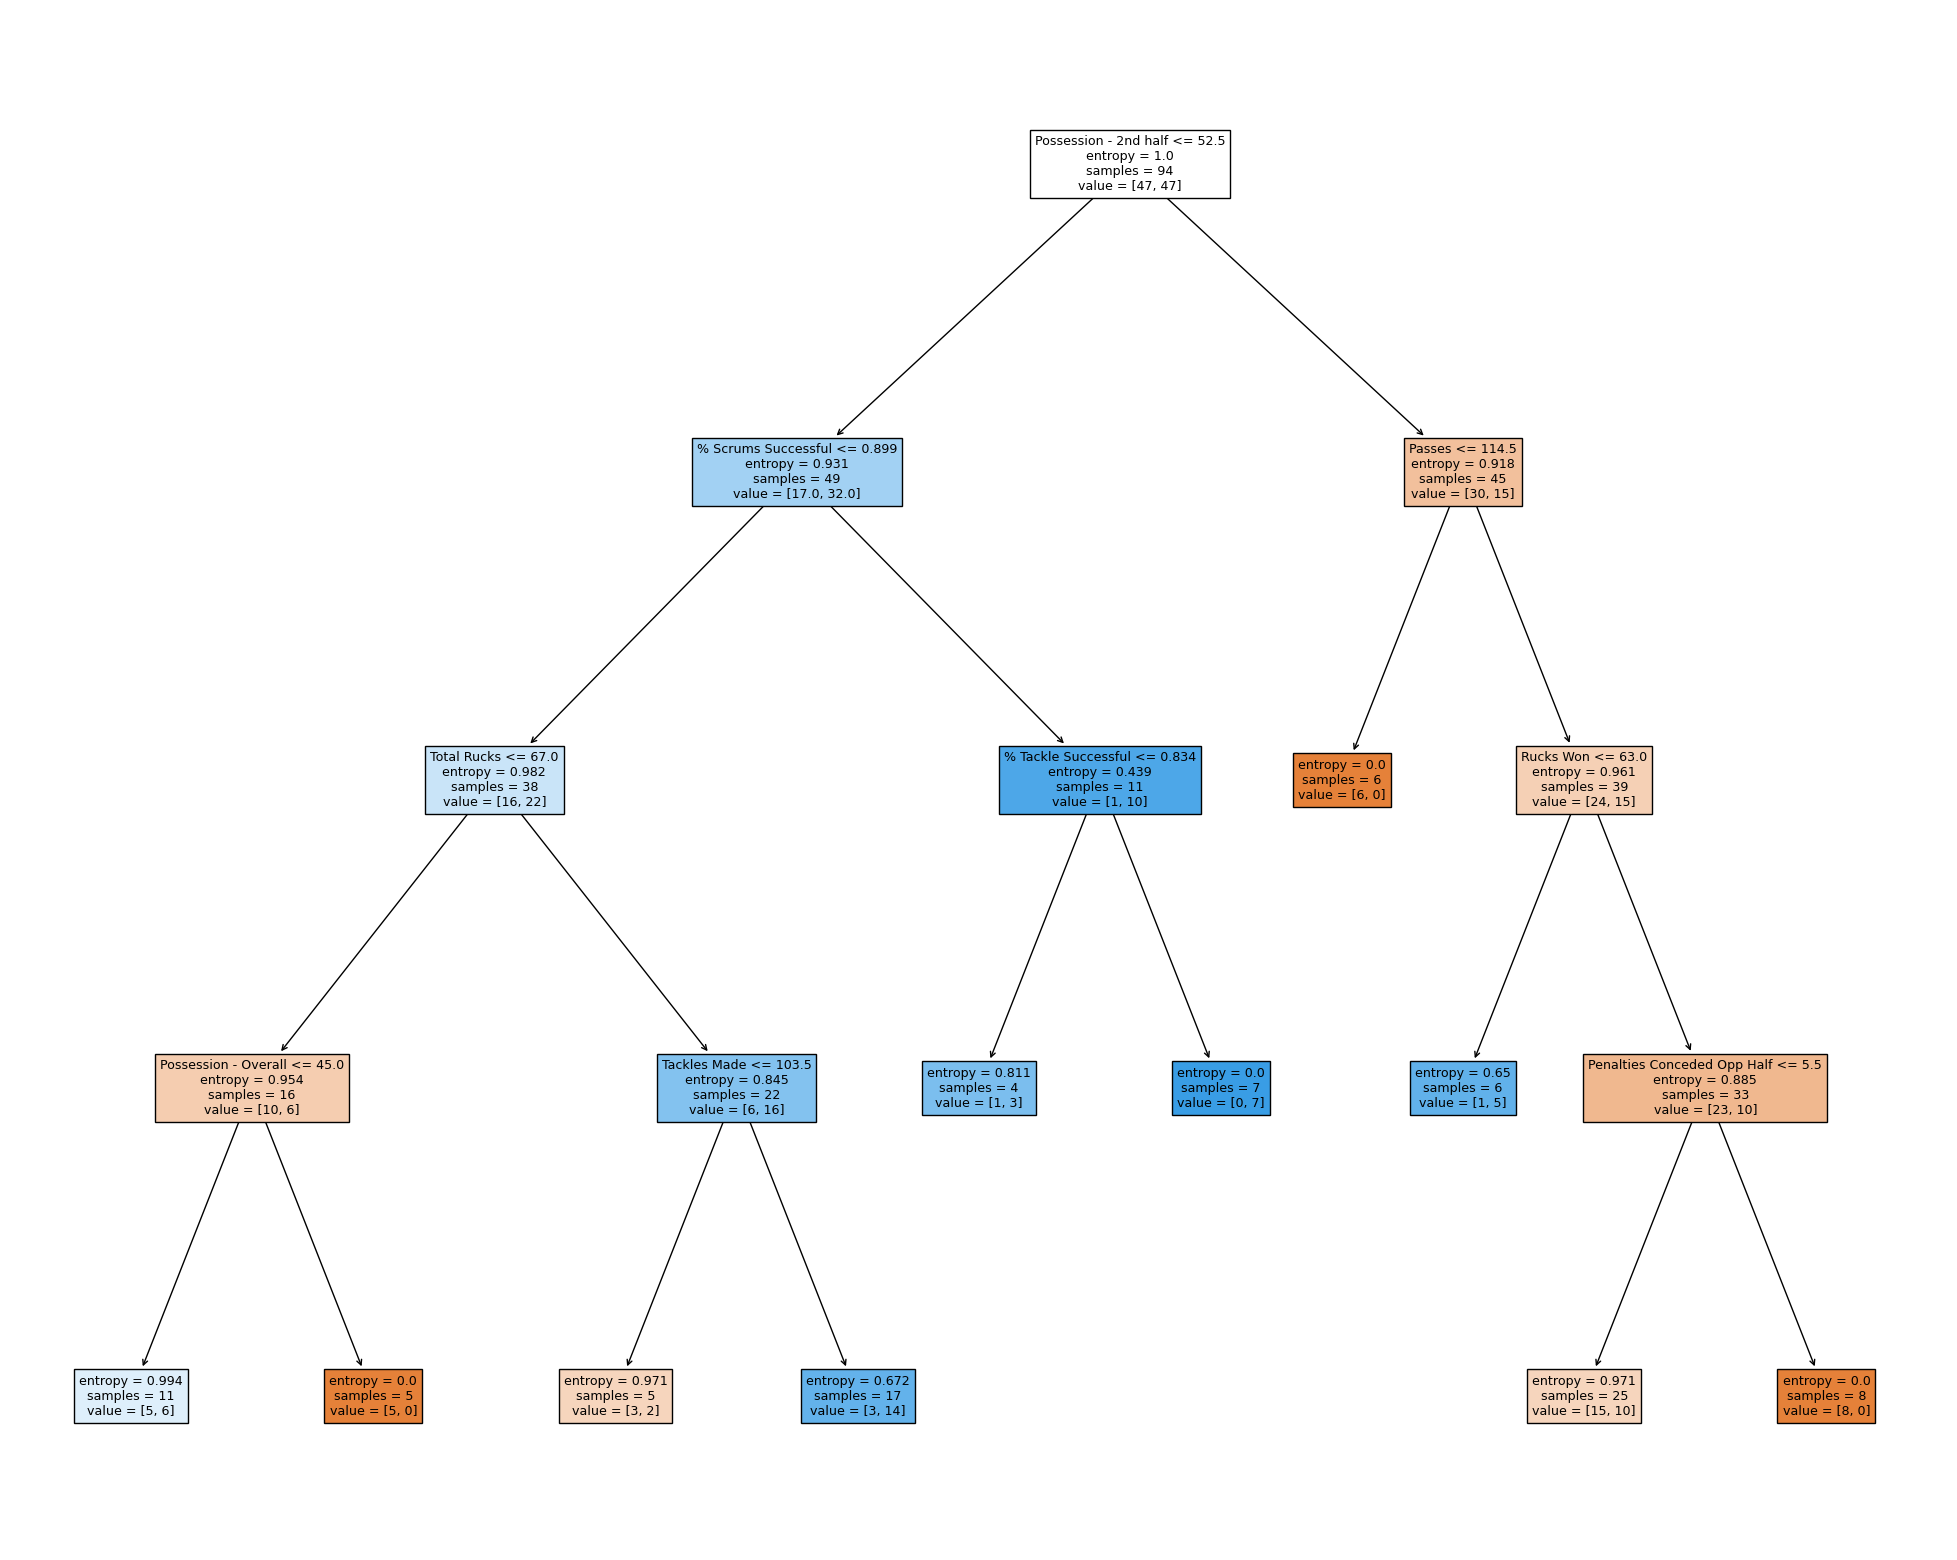

In [23]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_random , 
                   feature_names=features,  
                   
                   filled=True)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X , y, test_size = 0.400, random_state = 6)

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, Y_train)
base_accuracy = evaluate(base_model, X_test, Y_test)

NameError: name 'train_test_split' is not defined